In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

train_data = pd.read_csv('../downloads/titanic/train.csv')
test_data = pd.read_csv('../downloads/titanic/test.csv')

train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]

test_data["AgeBucket"] = test_data["Age"] // 15 * 15
test_data["RelativesOnboard"] = test_data["SibSp"] + test_data["Parch"]

train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

train_data['CabinExists'] = train_data['Cabin'].notna().astype(int)
test_data['CabinExists'] = test_data['Cabin'].notna().astype(int)

train_data.set_index("PassengerId")
test_data.set_index("PassengerId")

# Drop the target variable column
train_features = train_data.drop(columns=['Survived'])

# Define numerical and categorical attributes based on the modified training data
num_attribs = [col for col in train_features if train_features[col].dtype != 'object']
cat_attribs = [col for col in train_features if train_features[col].dtype == 'object']

# Define the numerical and categorical pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)) 
])

# Combine pipelines
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

# Apply the pipeline to training and testing data
X_train = full_pipeline.fit_transform(train_features)
X_test = full_pipeline.transform(test_data)

y_train = train_data['Survived']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [3]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

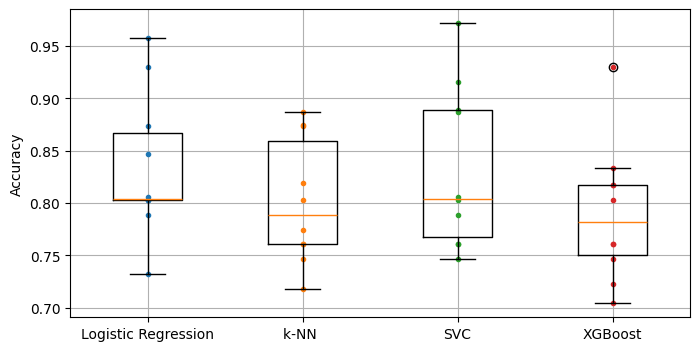

In [4]:
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_val)
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=10)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
knn_score = cross_val_score(knn, X_train, y_train, cv=10)

from sklearn.svm import SVC
svc = SVC(random_state=42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_val)
svc_score = cross_val_score(svc, X_train, y_train, cv=10)

from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
xgb_score = cross_val_score(xgb, X_train, y_train, cv=10)

plt.figure(figsize=(8, 4))
plt.plot([1]*10, log_reg_score, ".")
plt.plot([2]*10, knn_score, ".")
plt.plot([3]*10, svc_score, ".")
plt.plot([4]*10, xgb_score, ".")
plt.boxplot([log_reg_score, knn_score, svc_score, xgb_score], labels=("Logistic Regression","k-NN ","SVC","XGBoost"))
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [5]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# First, apply PCA to reduce dimensionality
pca_pipeline = Pipeline([
    ('pca', PCA(n_components=0.95)),
    ('svc', SVC(random_state=42))
])

# Define the parameter grid for SVC after PCA
param_grid_pca = {
    'svc__C': [0.01, 0.1, 1, 10, 100],
    'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'svc__kernel': ['rbf']
}

# GridSearchCV with PCA
grid_search_pca = GridSearchCV(pca_pipeline, param_grid_pca, refit=True, cv=10, scoring='accuracy')
grid_search_pca.fit(X_train, y_train)

# Get the best estimator and evaluate on validation set
best_svc_pca = grid_search_pca.best_estimator_
y_pred_pca = best_svc_pca.predict(X_val)

# Print the test accuracy after applying PCA
accuracy_pca = accuracy_score(y_val, y_pred_pca)
accuracy_pca

0.8603351955307262

In [6]:
predictions = best_svc_pca.predict(X_test)

submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': predictions
})

# Save the DataFrame to a CSV file
submission.to_csv('titanic_kaggle_submission3.csv', index=False)

submission.shape

(418, 2)